In [1]:
#import spacy
import pandas as pd
#from nltk.corpus import wordnet as wn
#import nltk
#import matplotlib.pyplot as plt
import re
#nlp = spacy.load('en_core_web_lg')
#dalloway = open('dalloway.txt', errors="ignore").read()
import altair as alt
%matplotlib inline

In [2]:
dalloway = open('data/dalloway.txt', errors='ignore').read()
xkcdMapRaw = open('data/xkcd/rgb.txt').readlines()[1:]
xkcdMap = {}
for line in xkcdMapRaw: 
    splitLine = line.split('\t') 
    if len(splitLine) != 3:
        print('error on: ', splitLine) 
    else:
        name, val, _ = line.split('\t')
        xkcdMap[name] = val


In [148]:
def annotateColors(text):
    matchLocs = {}
    for item in xkcdMap:
        pattern = '[\b\s]+' + item.replace(' ', '[-\s+]') + '[\b\s]+'
        matches = re.finditer(pattern, text, flags=re.IGNORECASE)
        matchStarts =  [match.start() for match in matches if matches is not None]
        if matchStarts != []: 
            matchLocs[item] = len(matchStarts)
        color = xkcdMap[item]
        replacement = ' <span class="color" style="color: {}">{}</span> '.format(color, item)
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text, matchLocs

def chunk(text, n=10): 
    """ Split a text into N equal parts. """
    chunkSize = round(len(text)/n)
    return [text[i:i + chunkSize] for i in range(0, len(text), chunkSize)][:-1]

def count(text, nChunks=20):
    chunks = chunk(text, nChunks)
    df = pd.DataFrame([annotateColors(chunk)[1] for chunk in chunks])
    return df.fillna(0)

def melt(df): 
    df['chunk']=df.index
    return df.melt(id_vars='chunk', var_name='color', value_name='count')

def plotM(df, nColors=10):
    """ Plots with matplotlib, via pandas. """
    topColors = list(df.sum().sort_values(ascending=False)[:nColors].index)
    df[topColors].plot(kind='area', stacked=True, color=["xkcd:"+color for color in topColors], figsize=(12,8))
    
def plotA(df): 
    selection = alt.selection_interval(bind='scales')
    return alt.Chart(df, width=800, height=600).mark_area().encode(
                     x='chunk:O', y='count:Q', color=alt.Color('hex', scale=None), tooltip='color').add_selection(selection)

In [98]:
df = count(dalloway, nChunks=40)

In [114]:
df2 = melt(df)

In [121]:
df2sorted = df2.sort_values('hex')

In [116]:
df2['hex'] = df2['color'].apply(lambda x: xkcdMap[x])

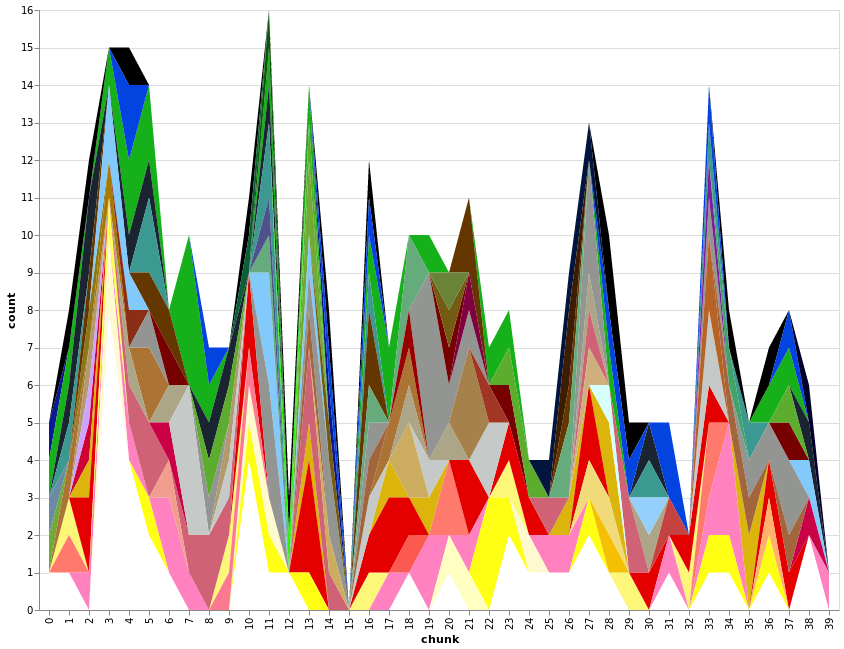

In [149]:
plotA(df2)